# List the files in the input directory

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import squarify
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


import os
print(os.listdir("input"))
### Variable Descrpition
pd.options.mode.chained_assignment = None

['.DS_Store', 'Country-Code.xlsx', 'file1.json', 'file2.json', 'file3.json', 'file4.json', 'zomato.csv']


# Renaming Variables to make intutitive

In [2]:
df_train = pd.read_csv('input/zomato.csv', encoding='latin-1')

df_train['rating_cat'] = df_train['Rating text'].map({'Not rated': -1, 
                                                      'Poor':0, 
                                                      'Average':2, 
                                                      'Good':3, 
                                                      'Very Good':4, 
                                                      'Excellent':5})

df_train.rename(columns = {'Aggregate rating':'rating_num', 
                           'Has Table booking': 'Book', 
                           'Has Online delivery': 'On_deliver', 
                           'Is delivering now':'Cur_deliver', 
                           'Switch to order menu' : 'Switch_menu', 
                           'Average Cost for two' : 'Avg_cost_two', 
                           'Price range' : 'Pr_range'}, inplace = True)

df_train.drop(['Rating color', 'Rating text'], axis = 1 ,inplace= True)

print('Original Train Row: ', df_train.shape[0])
#df_test = df_train.loc[df_train.rating_cat == -1, :].copy()

df_train = df_train.loc[df_train.rating_cat != -1, :].copy()
print('Train Row : ', df_train.shape[0])
#print('Test Row : ', df_test.shape[0])

Original Train Row:  9551
Train Row :  7403


# Y_Normal Distribution

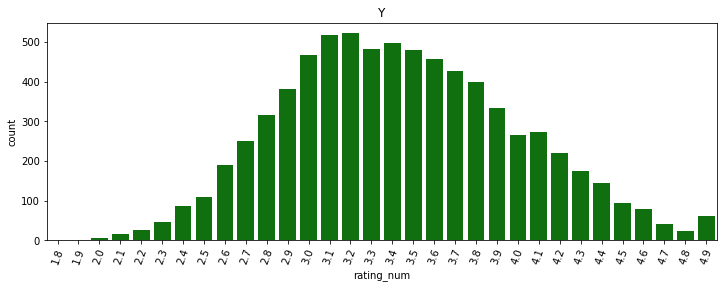

In [3]:
rating = ['rating_num', 'rating_cat']

f, ax = plt.subplots(1,1, figsize = (12, 4))
sns.countplot(df_train['rating_num'], ax = ax, color = 'green')
ax.tick_params('x', rotation = 70)
ax.set_title('Y')
plt.show()

## ID is unique, but Restuarant Name is overlapped

In [4]:
print('ID # / Name #')
df_train[['Restaurant ID','Restaurant Name']].apply(pd.Series.nunique, axis = 0)

ID # / Name #


Restaurant ID      7403
Restaurant Name    5711
dtype: int64

# Most of the data is from India with Indian Rupees as currency

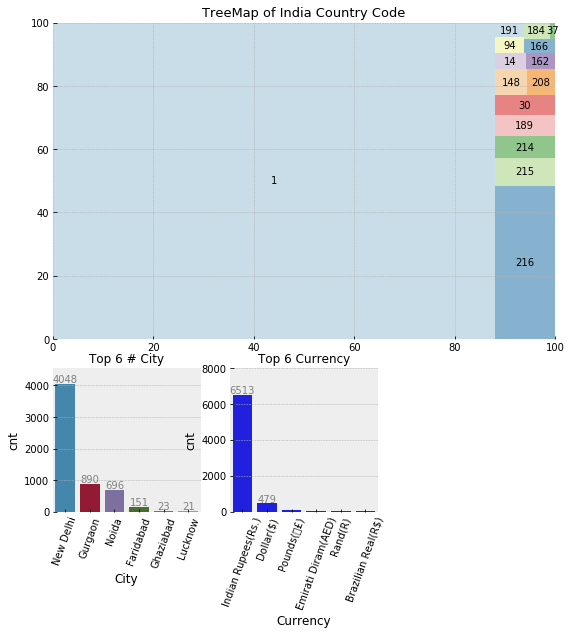

City #  141
Currency #  12
Country Code #  15


In [5]:
with plt.style.context('bmh'):
    f = plt.figure(figsize = (9,9))
    ax = plt.subplot2grid((3,3),(0,0), colspan = 3, rowspan = 2)
    #df_train[['Longitude', 'Latitude']].plot.hexbin(x='Longitude', y = 'Latitude', gridsize = 10, vmin = 100, vmax = 700, ax = ax)
    #ax.text(80, 40, 'India', color = 'red')
    #ax.text(-100, 45, 'USA', color = 'red')
    #ax.text(0,5, 'Missing Pos', color = 'grey')
    #ax.set_title('Controlled Plot')
    #ax.set_yticklabels([])
    #ax.set_xticklabels([])
    cnt = df_train['Country Code'].value_counts().to_frame()
    squarify.plot(sizes = cnt.values, label = cnt.index,
                  color = sns.color_palette('Paired', 11), alpha = 0.5, ax = ax)
    ax.set_title("TreeMap of India Country Code", fontsize = 13)


    ax = plt.subplot2grid((3,3),(2,0))
    cnt = df_train['City'].value_counts().reset_index()
    cnt.rename(columns = {'index':'City', 'City':'cnt'}, inplace = True)
    sns.barplot(x = 'City', y = 'cnt', data = cnt.head(6), ax = ax)
    ax.tick_params(axis='x', rotation=70)
    ax.set_title('Top 6 # City', size = 12)
    ax.set_ylim([0, cnt['cnt'].head(1).values+500])
    for i, val in enumerate(cnt['cnt'].head(6)):
        ax.text(i, val+50, val, color = 'grey', ha = 'center')

    ax = plt.subplot2grid((3,3),(2,1))
    cnt = df_train['Currency'].value_counts().reset_index()
    cnt.rename(columns = {'index':'Currency', 'Currency':'cnt'}, inplace = True)
    sns.barplot(x = 'Currency', y = 'cnt', data =cnt.head(6), color = 'b', ax = ax)
    ax.set_title('Top 6 Currency', size = 12)
    ax.tick_params(axis='x', rotation=70)
    ax.set_ylim([0, 8000])
    for i, val in enumerate(cnt['cnt'].head(2)):
        ax.text(i, val+50, val, color = 'grey', ha = 'center')
    sns.despine(left=True, bottom=True)
    plt.show()

    
    
print('City # ', df_train['City'].nunique())
print('Currency # ', df_train['Currency'].nunique())
print('Country Code # ', df_train['Country Code'].nunique())

### We gathered New Delhi restaurants and found unstable rating variables.

In [6]:
df_city = df_train.loc[(df_train['Country Code'] == 1) & (df_train['City'] == 'New Delhi'), :]
df_city.drop(['Country Code', 'City', 'Locality Verbose', 'Currency'], axis = 1, inplace = True)
df_city = df_city.loc[df_city['Longitude'] != 0, :]

tmp = df_city['rating_num'].map(np.round)
a = np.full(tmp.shape[0], False, dtype = bool)
print('Round')
((tmp - df_city['rating_cat']).map(np.round)).value_counts()

Round


 1.0    3490
 0.0     378
 2.0      96
-1.0      11
dtype: int64

### 'rating_cat' and 'rating_num' are not identical score. The difference is 2. Rounded the categorical variables.

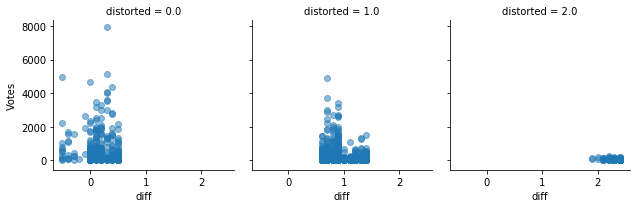

In [7]:
sys_check = df_city[['rating_num', 'rating_cat', 'Votes']].copy()
sys_check['distorted'] = (df_city['rating_num'] - df_city['rating_cat']).map(np.round)
sys_check['diff'] = sys_check['rating_num'] - sys_check['rating_cat']
g = sns.FacetGrid(data =sys_check, col = 'distorted')
g = g.map(plt.scatter, 'diff', 'Votes', alpha = 0.5)
df_city = df_city.loc[sys_check['distorted'] != 2, :]
df_city['rating_cat'] = df_city['rating_num'].round(0).astype(int)


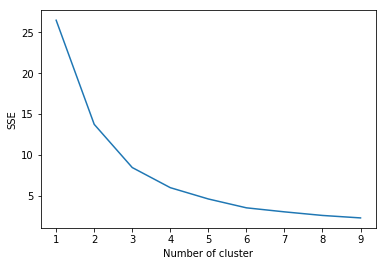

In [8]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=15).fit(df_city[['Longitude', 'Latitude']])

    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

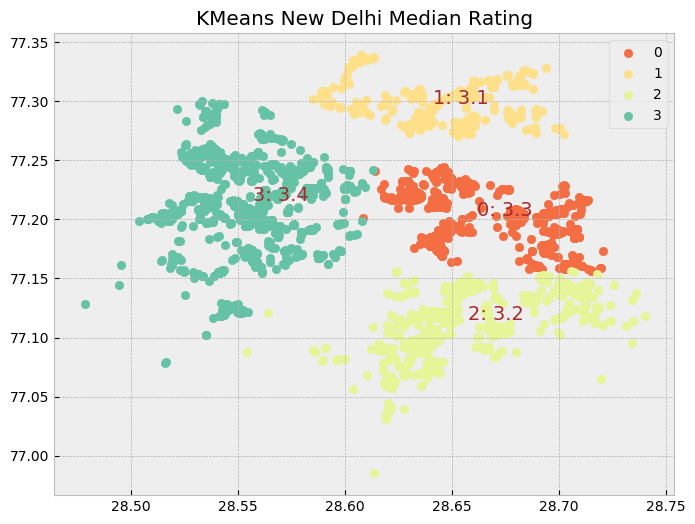

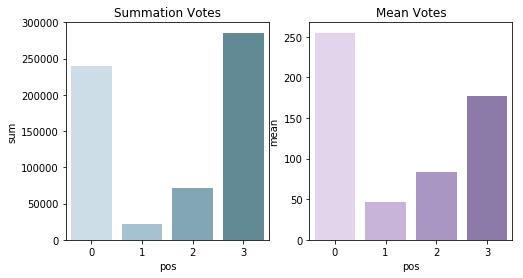

In [9]:

kmeans = KMeans(n_clusters=4,  max_iter=10).fit(df_city[['Longitude', 'Latitude']])
df_city['pos'] = kmeans.labels_
pop_local = df_city.groupby('pos')['Longitude', 'Latitude', 'rating_num'].agg({'Longitude':np.mean, 'Latitude':np.mean, 'rating_num':np.median}).reset_index()

with plt.style.context('bmh', after_reset=True):
    pal = sns.color_palette('Spectral', 4)
    plt.figure(figsize = (8,6))
    for i in range(4):
        ix = df_city.pos == i
        plt.scatter(df_city.loc[ix, 'Latitude'], df_city.loc[ix, 'Longitude'], color = pal[i], label = str(i))
        plt.text(pop_local.loc[i, 'Latitude'], pop_local.loc[i, 'Longitude'], str(i) + ': '+str(pop_local.loc[i, 'rating_num'].round(2)), fontsize = 14, color = 'brown')
    plt.title('KMeans New Delhi Median Rating')
    plt.legend()
    plt.show()
    
    
votes_area = df_city.groupby('pos').agg({'Votes': [np.sum, np.mean]})
votes_area.columns = votes_area.columns.droplevel(0)
votes_area.reset_index(inplace = True)
plt.figure(figsize = (8,4))
ax = plt.subplot(1,2,1)
sns.barplot(x = 'pos', y = 'sum', data =votes_area, palette = sns.cubehelix_palette(n_colors = 7, start = 2.4, rot = .1), ax = ax)
ax.set_title('Summation Votes')

ax = plt.subplot(1,2,2)
sns.barplot(x = 'pos', y = 'mean', data =votes_area, palette = sns.cubehelix_palette(n_colors = 7, start = 3, rot = .1), ax = ax)
ax.set_title('Mean Votes')
plt.show()

### From K-means clustering, the Central city is attractive than North and South of the city. Voting mean and count is higher in Central part of the city. 

Text(0.5,1,'Rating Cnt')

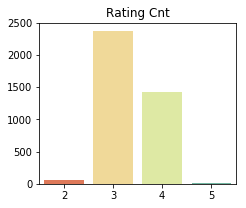

In [10]:
ax = plt.subplot2grid((4,5), (0,0), colspan = 3, rowspan = 3)
tmp = df_city['rating_cat'].value_counts().sort_index()
sns.barplot(tmp.index, tmp.values, palette= pal)
ax.set_title('Rating Cnt')

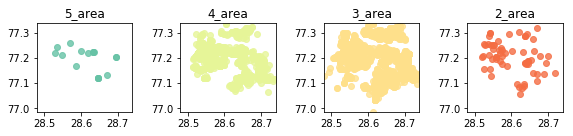

In [12]:
plt.figure(figsize = (12,9))
cat = sorted(df_city['rating_cat'].unique().tolist())
x_lm = [df_city['Latitude'].min(), df_city['Latitude'].max()]
y_lm = [df_city['Longitude'].min(), df_city['Longitude'].max()]
for i, c in enumerate(reversed(cat)):
    ax = plt.subplot2grid((4,5), (3,i))
    ix = df_city.rating_cat == c
    ax.scatter(df_city.loc[ix, 'Latitude'], df_city.loc[ix, 'Longitude'], color = pal[len(cat)-1-i], alpha = 0.8)
    ax.set_xlim(x_lm)
    ax.set_ylim(y_lm)
    ax.set_title(str(c) + '_area')

plt.subplots_adjust(hspace=0.5, wspace = 0.5)
plt.show()

## The bottom 5_area reminds that in North New Delhi there are no restaurants with rating 5. Moreover the North and South part of New Delhi have comparitively less rated restaurants than Central part of the city.